
<br>
Observation des réseaux de relations entre les différentes occupations des écrivain-es. Continuation nocturne du carnet "reseaux_occupations".<br>


In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import re

L'adresse de DBPedia, où la requête doit être adressée.

In [2]:
sparql = SPARQLWrapper("http://dbpedia.org/sparql")

Le format du résultat de la requête. L'objet, en python, sera un dictionnaire.

In [3]:
sparql.setReturnFormat(JSON)

La requête, qui trouve les Writers et leurs occupations.

In [4]:
sparql.setQuery(
    "PREFIX dbo: <http://dbpedia.org/ontology/>\n"
    "PREFIX dbr: <http://dbpedia.org/resource/>\n"
    "\n"
    "SELECT DISTINCT ?person ?occupation\n"
    "WHERE {\n"
    "    ?person ?a dbr:Writer ;\n"
    "            dbo:occupation ?occupation .\n"
    "}\n"
)

Envoyer la requête.

In [5]:
results = sparql.queryAndConvert()

Aperçu de la structure de l'objet retourné. Le premier niveau du dictionnaire.

In [6]:
results.keys()

dict_keys(['head', 'results'])

L'entrée "head" (en-tête), qui décrit la structure des données.

In [7]:
results["head"]

{'link': [], 'vars': ['person', 'occupation']}

L'entrée "results".

In [8]:
for i, j in results["results"].items():
    if type(j) == list:
        print(f'results["results"]["{i}"]:', type(j), j[:2])
    elif type(j) == dict:
        print(
            f'results["results"]["{i}"]:', type(j), list(j.keys())[:3]
        )
    else:
        print(f'results["results"]["{i}"]:', type(j), j)

results["results"]["distinct"]: <class 'bool'> False
results["results"]["ordered"]: <class 'bool'> True
results["results"]["bindings"]: <class 'list'> [{'person': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Caiseal_Mór'}, 'occupation': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Musician'}}, {'person': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Caiseal_Mór'}, 'occupation': {'type': 'uri', 'value': 'http://dbpedia.org/resource/Artist'}}]


Seul ce qui se trouve dans ['results']['bindings'] m'intéresse. Je commence par construire un simple liste de tuples selon le schéma (person, occupation).

In [9]:
pairs = [
    (i["person"]["value"], i["occupation"]["value"])
    for i in results["results"]["bindings"]
]
pairs[:3]

[('http://dbpedia.org/resource/Caiseal_Mór',
  'http://dbpedia.org/resource/Musician'),
 ('http://dbpedia.org/resource/Caiseal_Mór',
  'http://dbpedia.org/resource/Artist'),
 ('http://dbpedia.org/resource/Caiseal_Mór',
  'http://dbpedia.org/resource/Writer')]

Pour augmenter le nombre de données (la raison apparaitra plus bas, mais repose sur la limitation à 10000 résultats par requête auprès de dbpedia), je fais également des requêtes avec d'autres occupations que Writers.

In [10]:
groups = ["Novelist", "Poet", "Playwright"]
for i in groups:
    q = SPARQLWrapper("http://dbpedia.org/sparql")
    q.setReturnFormat(JSON)
    q.setQuery(
        "PREFIX dbo: <http://dbpedia.org/ontology/>\n"
        "PREFIX dbr: <http://dbpedia.org/resource/>\n"
        "\n"
        "SELECT DISTINCT ?person ?occupation\n"
        "WHERE {\n"
        f"    ?person ?a dbr:{i} ;\n"
        "            dbo:occupation ?occupation .\n"
        "}\n"
    )
    res = sparql.queryAndConvert()
    p = [
        (i["person"]["value"], i["occupation"]["value"])
        for i in res["results"]["bindings"]
    ]
    pairs.extend(p)

J'enlève le début des URI, pour ne garder que les noms et les occupations.

In [11]:
clean_pairs = [
    (
        i.replace("http://dbpedia.org/resource/", ""),
        # Je passe les occupations en lowercase pour faciliter
        # les recherches de caractères.
        j.replace("http://dbpedia.org/resource/", "").lower(),
    )
    for i, j in pairs
]
clean_pairs[:3]

[('Caiseal_Mór', 'musician'),
 ('Caiseal_Mór', 'artist'),
 ('Caiseal_Mór', 'writer')]

Certaines paires me sont inutiles, celles qui ont comme occupation "[nom de la personne]_PersonFunction".

In [12]:
[i for i in clean_pairs if "personfunction" in i[1]][:5]

[('Caitlin_Flanagan', 'caitlin_flanagan__personfunction__1'),
 ('Carl_Washington', 'carl_washington__personfunction__1'),
 ('Carlo_Mattogno', 'carlo_mattogno__personfunction__1'),
 ('Carlos_Alberto_Montaner', 'carlos_alberto_montaner__personfunction__1'),
 ('Carlos_Francisco_Chang_Marín',
  'carlos_francisco_chang_marín__personfunction__1')]

Je construis donc une nouvelle liste sans ces paires.

In [13]:
non_trivial_pairs = [
    i for i in clean_pairs if "personfunction" not in i[1]
]
len(non_trivial_pairs)

25680

Il y a des répétitions de paires, puisque les Novelist, les Poets, etc., sont souvent aussi catégorisé-es comme Writer. En fait, l'ajout des nouveaux groupes n'a peut-être pas été si utile. [À faire, peut-être: ajouter des occupations liées à la littérature mais plutôt, par exemple, du côté des éditeurices, des bibliothécaires, des critiques. Ou, à l'inverse, des artistes, des musicien-nes, pour voir si les activités annexes sont du même type, s'il y a des recoupements, etc.]

In [14]:
uniqpairs = list(set(non_trivial_pairs))
len(uniqpairs)

6420

Je vais aussi éliminer les occupations pour lesquelles il y a une seule occurrence.

In [15]:
occupations = [j for i, j in uniqpairs]
notuniqocc = []
count = Counter(occupations)
for i, j in count.items():
    if j > 1:
        notuniqocc.append(i)
uniqpairs = [(i, j) for i, j in uniqpairs if j in notuniqocc]
uniqpairs[:3]

[('Richard_Gordon_(English_author)', 'writer'),
 ('Adam_Grzymała-Siedlecki', 'critic'),
 ('Jamie_Kilstein', 'radio_personality')]

Puisque ce sont les interactions entre occupations qui m'intéresse, je ne vais garder que les données qui concernent les personnes avec au moins deux entrées. Je commence par faire une liste des noms.

In [16]:
names = [i for i, j in uniqpairs]
names[:3]

['Richard_Gordon_(English_author)',
 'Adam_Grzymała-Siedlecki',
 'Jamie_Kilstein']

Le nombre total d'occurences de noms.

In [17]:
len(names)

5816

Le nombre d'occurences de noms qui apparaissent plusieurs fois.

In [18]:
names_repeated = [i for i in names if names.count(i) > 1]
len(names_repeated)

4520

Le nombre de noms qui apparaissent plusieurs fois. (Les données sont plus minces que ce que je pouvais espérer et il faudrait probablement opter pour une autre manière d'interroger DBPedia.)

In [19]:
len(set(names_repeated))

1647

Les premiers noms.

In [20]:
uniqnames = list(set(names_repeated))
uniqnames.sort()
for i in uniqnames[:5]:
    print(i)

A._C._Sreehari
A._Dorian_Otvos
A._N._Murthy_Rao
Aaron_Ehasz
Abd_Al_Munim_Al_Gilyani


Puisque chaque nom est unique, je peux utiliser les noms comme clés pour un dictionnaire. La valeur qui y sera attribuée sera une liste des occupations.

In [21]:
d = {}
for i in uniqnames:
    d[i] = []

Observer le dictionnaire avant d'y mettre les données.

In [22]:
for i in list(d.items())[:3]:
    print(i)

('A._C._Sreehari', [])
('A._Dorian_Otvos', [])
('A._N._Murthy_Rao', [])


Iterate sur les éléments de la variable clean_pairs qui contient les paires person/occupation, et append la liste des occupations de la personne

In [23]:
for name, occupation in uniqpairs:
    if name in uniqnames:
        d[name].append(occupation)

Observer une partie du dictionnaire.

In [24]:
for i in list(d.items())[:3]:
    print(i)

('A._C._Sreehari', ['lyricist', 'writer', 'teacher', 'poet'])
('A._Dorian_Otvos', ['composer', 'writer'])
('A._N._Murthy_Rao', ['professor', 'writer'])


L'occupation "Writer" est très présente C'est pour cela que j'ai fait des requêtes supplémentaires. Cela a permis d'ajouter un certain nombre d'entrées.

In [25]:
len([i for i, j in list(d.items()) if "writer" not in j])

520

Mais la question se pose, tout de même, de l'intérêt ici de l'occupation "Writer" (qui est aussi, dans DBPedia, une méta-occupation). Je préfère la retirer, étant donné que les poète-sses, les romancier-ères, les dramaturges, sont aussi des écrivain-es. Puisque les réseaux que je vais construire sont des réseaux d'occupations annexes à l'écriture, il est inutile que tous les points du réseaux soient reliés à un point central "écriture": c'est leur intégration au graphe qui constitue cette relation commune.

In [26]:
data_to_pop = [
    i for i in list(d.keys()) if len(d[i]) < 3 and "writer" in d[i]
]
len(data_to_pop)
for i in data_to_pop:
    d.pop(i)

Enlever également des entrées restantes l'item 'writer'.

In [27]:
for i, j in d.items():
    if "writer" in j:
        d[i].pop(d[i].index("writer"))

Le nombre d'entrées restantes dans le dictionnaires.

In [28]:
len(d)

1106

Il va désormais s'agir d'explorer les relations entre occupations en utilisant l'analyse de réseaux. Pour le début de l'exploration, je vais simplifier les données et regarder les relations d'occupations uniquement, en excluant les personnes des graphes, ou plus exactement: je vais créer un graphe avec un seul type de noeud, les occupations, et en réduisant les personnes à des nombres qui renforceront le poids des relations entre les noeuds-occupations. Plus une relation entre deux occupations (deux noeuds) sera répandue, et plus le lien entre elles sera considéré comme lourd.<br>
Pour créer un réseau reliant les occupations les unes aux autres, il faut d'abord créer des relations entre occupations, des nouvelles paires occupation/occupation.

In [29]:
occ_pairs = []
for name, occupations in d.items():
    for occ_one in occupations:
        for occ_two in occupations:
            if occ_two != occ_one:
                o = [occ_one, occ_two]
                o.sort()
                p = (o[0], o[1])
                occ_pairs.append(p)

Certaines paires ont plusieurs occurences: quand deux occupations cohabitent chez plusieurs personnes.

In [30]:
[i for i in occ_pairs if "biographer" in i and "novelist" in i][:10]

[('biographer', 'novelist'),
 ('biographer', 'novelist'),
 ('biographer', 'novelist'),
 ('biographer', 'novelist'),
 ('biographer', 'novelist'),
 ('biographer', 'novelist'),
 ('biographer', 'novelist'),
 ('biographer', 'novelist')]

Plutôt que d'avoir ainsi des doublons, on peut représenter le nombre d'occurences comme la force de la relation. Observer les relations avec le plus d'occurences.

In [31]:
count = Counter(occ_pairs)
count.most_common()[:10]

[(('film_director', 'film_producer'), 164),
 (('film_director', 'screenwriter'), 130),
 (('actor', 'film_director'), 86),
 (('television_producer', 'television_writer'), 76),
 (('film_producer', 'screenwriter'), 70),
 (('screenwriter', 'television_producer'), 66),
 (('journalist', 'poet'), 66),
 (('playwright', 'poet'), 62),
 (('novelist', 'poet'), 62),
 (('actor', 'film_producer'), 56)]

In [32]:
def faire_un_graphe_simple_most_common(relations, nb: str):
    """
    Construit un graphe (avec visualisation) des relations les plus répandues.
    En paramètre: une liste de relations et le nombre de relations à sélectionner.
    """
    # Compter les relations.
    count = Counter(relations)
    relations_selected = [
        (i[0], i[1], j) for i, j in list(count.most_common()[:nb])
    ]
    # Construire le graphe
    g = nx.Graph()
    for relation in relations_selected:
        node1, node2 = relation[0], relation[1]
        g.add_edge(node1, node2)
    # Tracer le graphe.
    plt.figure(figsize=(30, 30))
    pos = nx.spring_layout(g)
    nx.draw_networkx_nodes(g, pos, alpha=0.6, node_size=10)
    nx.draw_networkx_edges(g, pos, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=9)
    fp = f'img/most_common_{nb}.svg'# io.BytesIO()
    plt.savefig(fp, format="svg")
    plt.show()

Construction d'un graphe avec ces paires d'occupations.

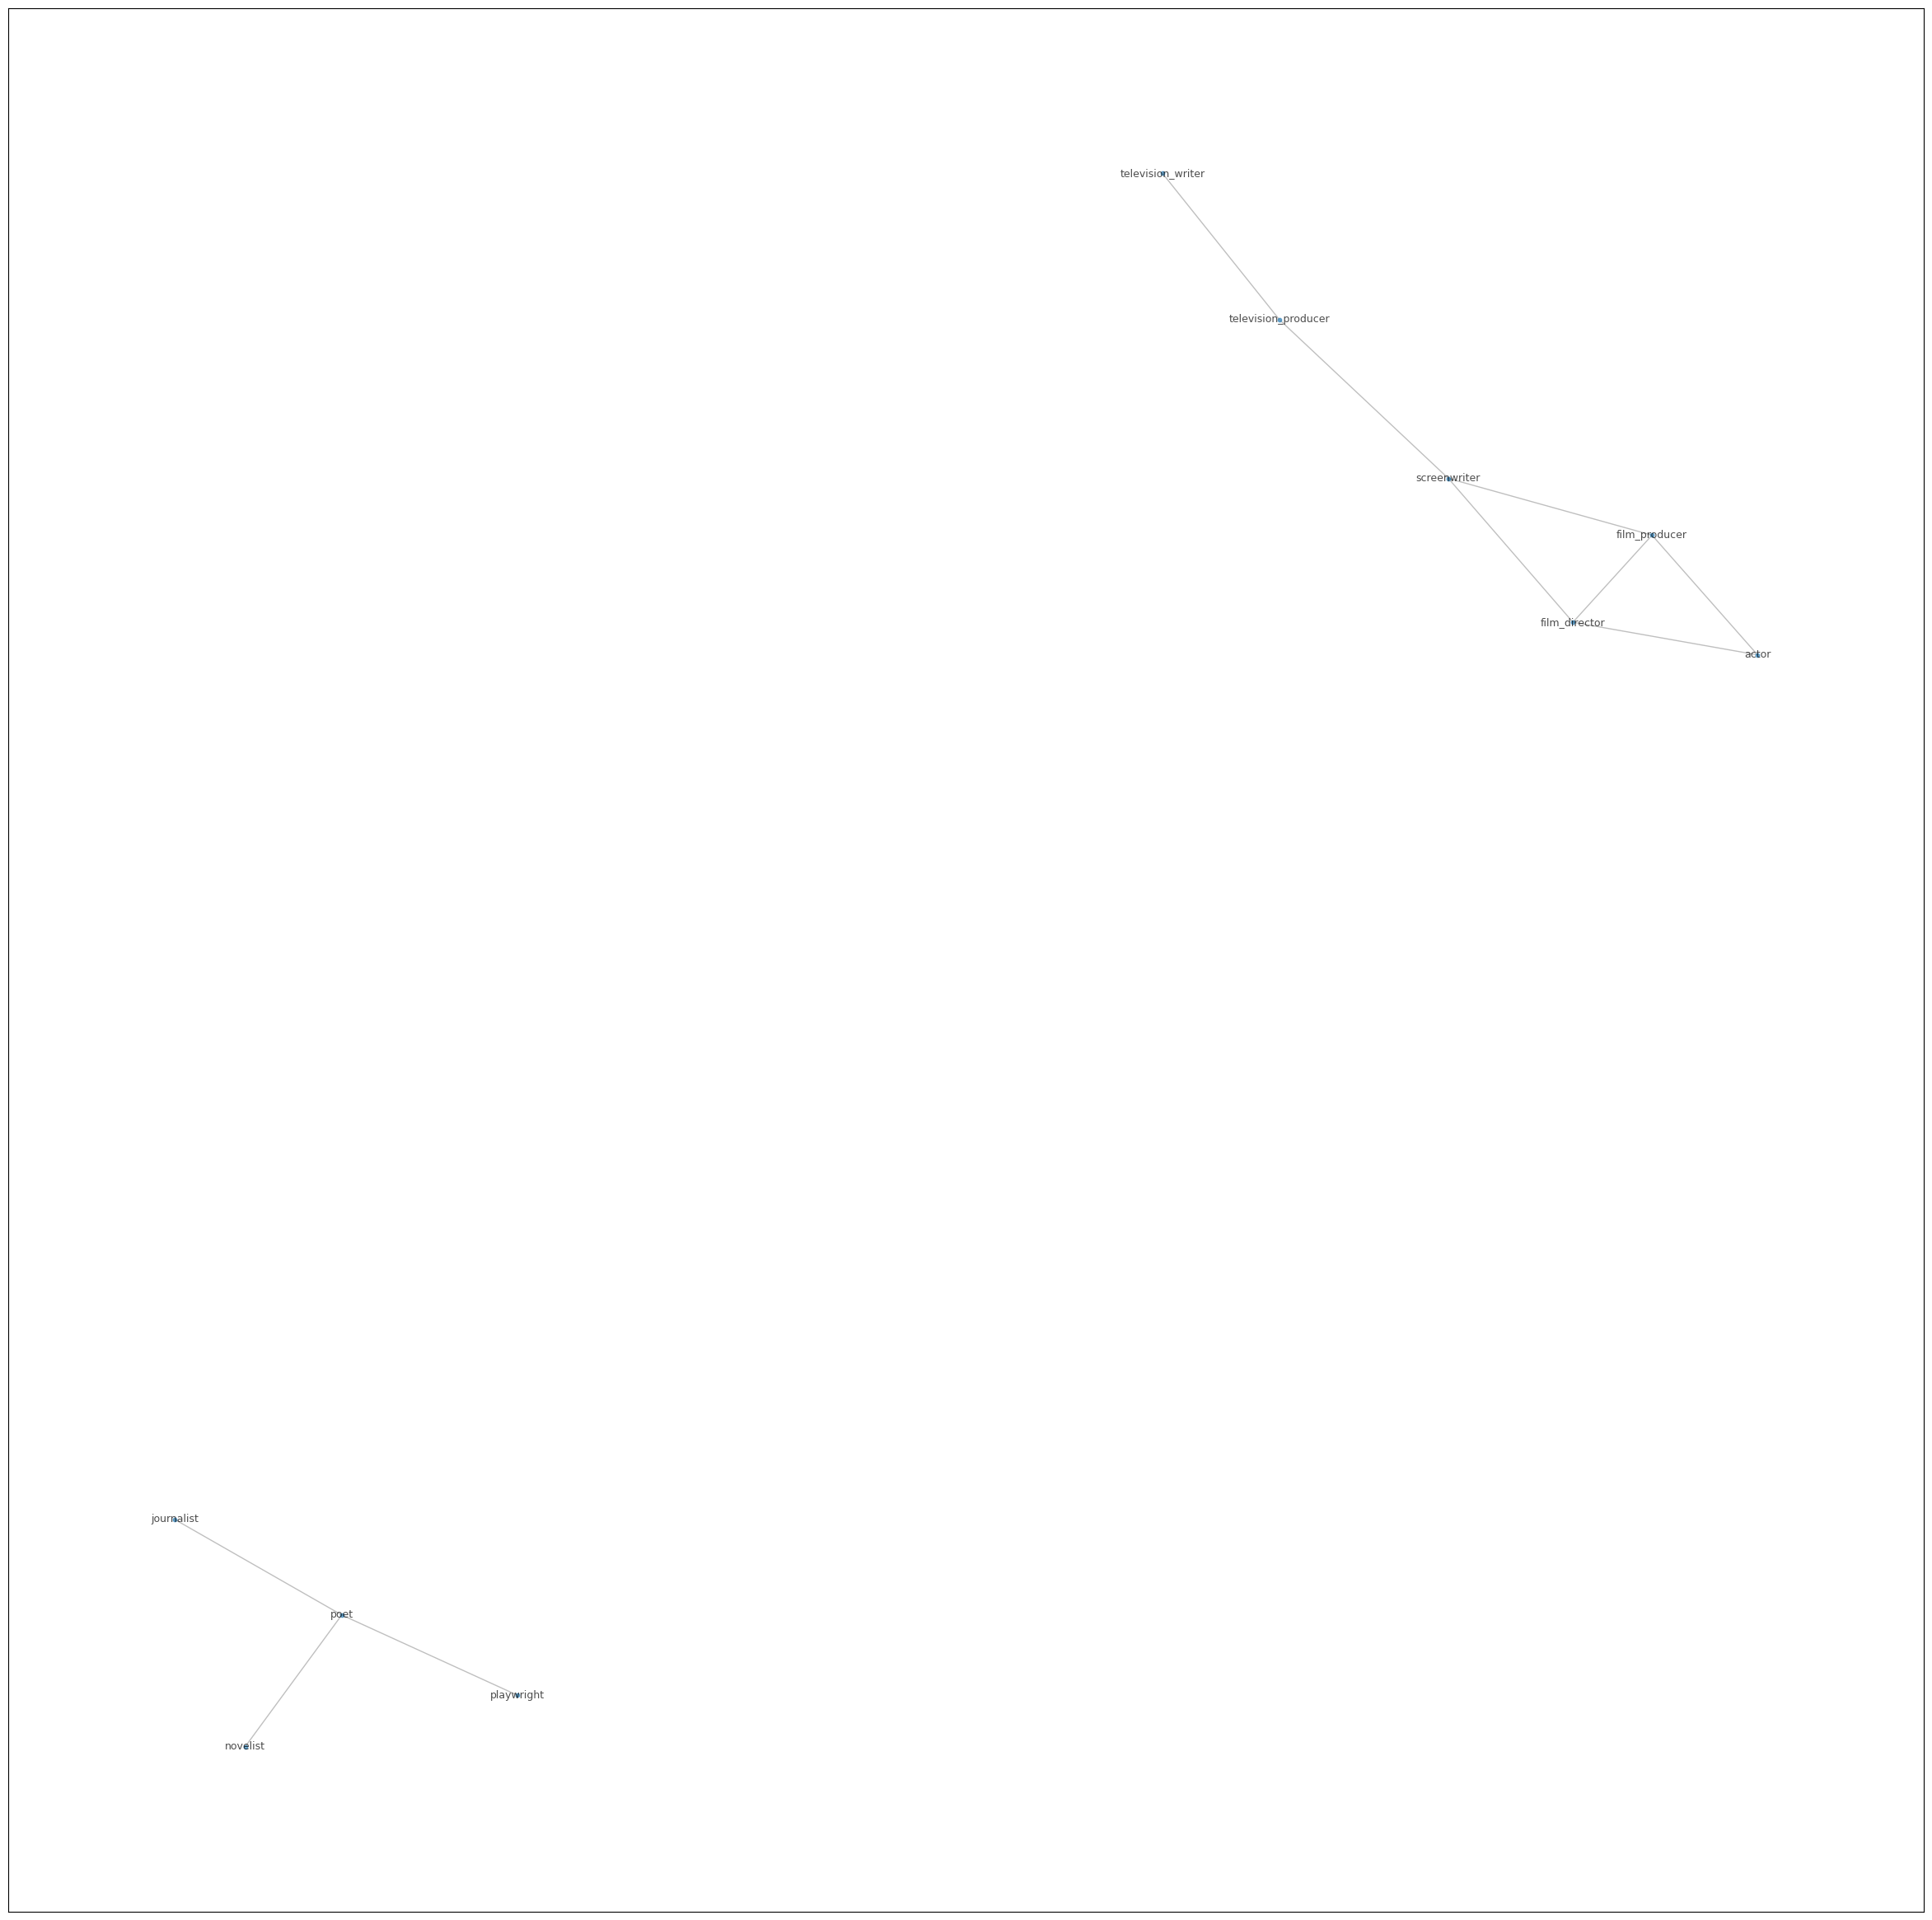

In [33]:
faire_un_graphe_simple_most_common(occ_pairs, 10)

Cette première visualisation nous montre déjà des choses intéressantes, quoi que relativement triviales. Le graphe est séparé en deux clusters: les écritures littéraires et le journalisme d'un côté, les activités liées au cinéma ou à la télévision de l'autre. Ce premier découpage est intéressant du fait de l'annexion de l'occupation journalistique aux écritures littéraires. Le journalisme, du point de vue de ce graphe, peut bien apparaître, d'une part, comme un métier d'appoint typique des littérateurices; et d'autre part comme un espace d'expression publique dont les littérateurices se saisissent davantage que d'autres groupes d'écrivain-es. Surtout, ce découpage en deux clusters est moins un découpage entre deux types d'activités qu'entre deux "mondes de l'art" au sens de Howard Becker. Car, d'un point de vue technique, technologique, physiologique, etc., l'écriture pour la télévision est bien plus proche de l'écriture d'une pièce de théâtre que de l'acting. À moins qu'on entende par "écriture" un ensemble large de pratiques intégrant les formes de collaboration (réécrire sous la contrainte des équipes de tournages, discuter, reprendre des parties de scripts existants, etc.), auquel cas "l'écriture" du screenwriter a en effet beaucoup à voir avec l'acting, puisqu'il s'agit essentiellement d'une activité consistant à employer les mêmes critères et à cotoyer les mêmes personnes: celles et ceux du monde du cinéma.<br>
Par ailleurs, on peut voir, dans le cluster lié au cinéma, que les nodes 'actor' et 'television writer' sont très éloigné, tandis que les nodes 'actor' et 'screen writer' (l'écriture pour le cinéma) sont plus rapprochés: on peut ainsi faire l'hypothèse que le monde de la télévision n'est pas structuré avec la même souplesse que le monde du cinéma, et que l'assignation à des rôles professionnels définis y est plus forte. Toutefois, il faut fortement relativiser cette hypothèse: ces résultats sont probablement liés au biais induit par la sélection des paires d'occupations les plus courantes.

La sociologie des Mondes de l'art de Howard Becker semble d'ailleurs particulièrement approprié ici, davantage, par exemple, que la théorie des champs de Bourdieu (qui conçoit le fonctionnement du champ littéraire comme un ensemble de positions). Becker, en effet, décrit les mondes de l'art comme des "réseaux de coopérations", et le succès de la réalisation d'une oeuvre d'art est en fait moins la conséquence des 'talents' de l'artiste que de la capacité de l'artiste à coopérer avec les autres membres du réseaux. Les artistes doivent apprendre à manier les jeux de langages et les critères des autres corps professionnels avec lesquels iels sont amené-es à collaborer. Il leur est donc naturellement plus facile de jouer elleux-mêmes ces rôles (occupations).

Je produis une autre visualisation avec un nombre plus grand de données sélectionnées pour construire le graphe, pour observer ce qu'il se passe si l'on modifie progressivement le grain avec lequel on observe ces données. Les deux clusters sont toujours séparés. De nouveaux points apparaissent des deux côtés, et se montre particulièrement intéressant dans le cluster littéraire. Le rôle de traduction est associé aux poètes (je commenté cela dans un autre carnet), et les romancier-ères sont associé-es à deux nouveaux noeuds: (1) l'écriture de short-stories (de nouvelles), qui apparait ainsi comme une forme apparentée au roman, écrite avec les mêmes logiques; (2) l'écriture essayiste, ce qui n'est pas étonnant étant donné que certains des romans modernes les plus importants du 20e siècle sont souvent perçues sous le prisme de l'essayisme (par exemple Proust ou Musil). Tout cela montre le statut particulier du roman dans l'histoire littéraire moderne: forme hybride à la fois narrative et réflexive, forme souple et "totale" qui a la capacité d'absorber tous les autres genres littéraires (ici: novelist est le seul point qui est connecté à tous les autres points littéraires: poet, playwright, essayist, short-story).

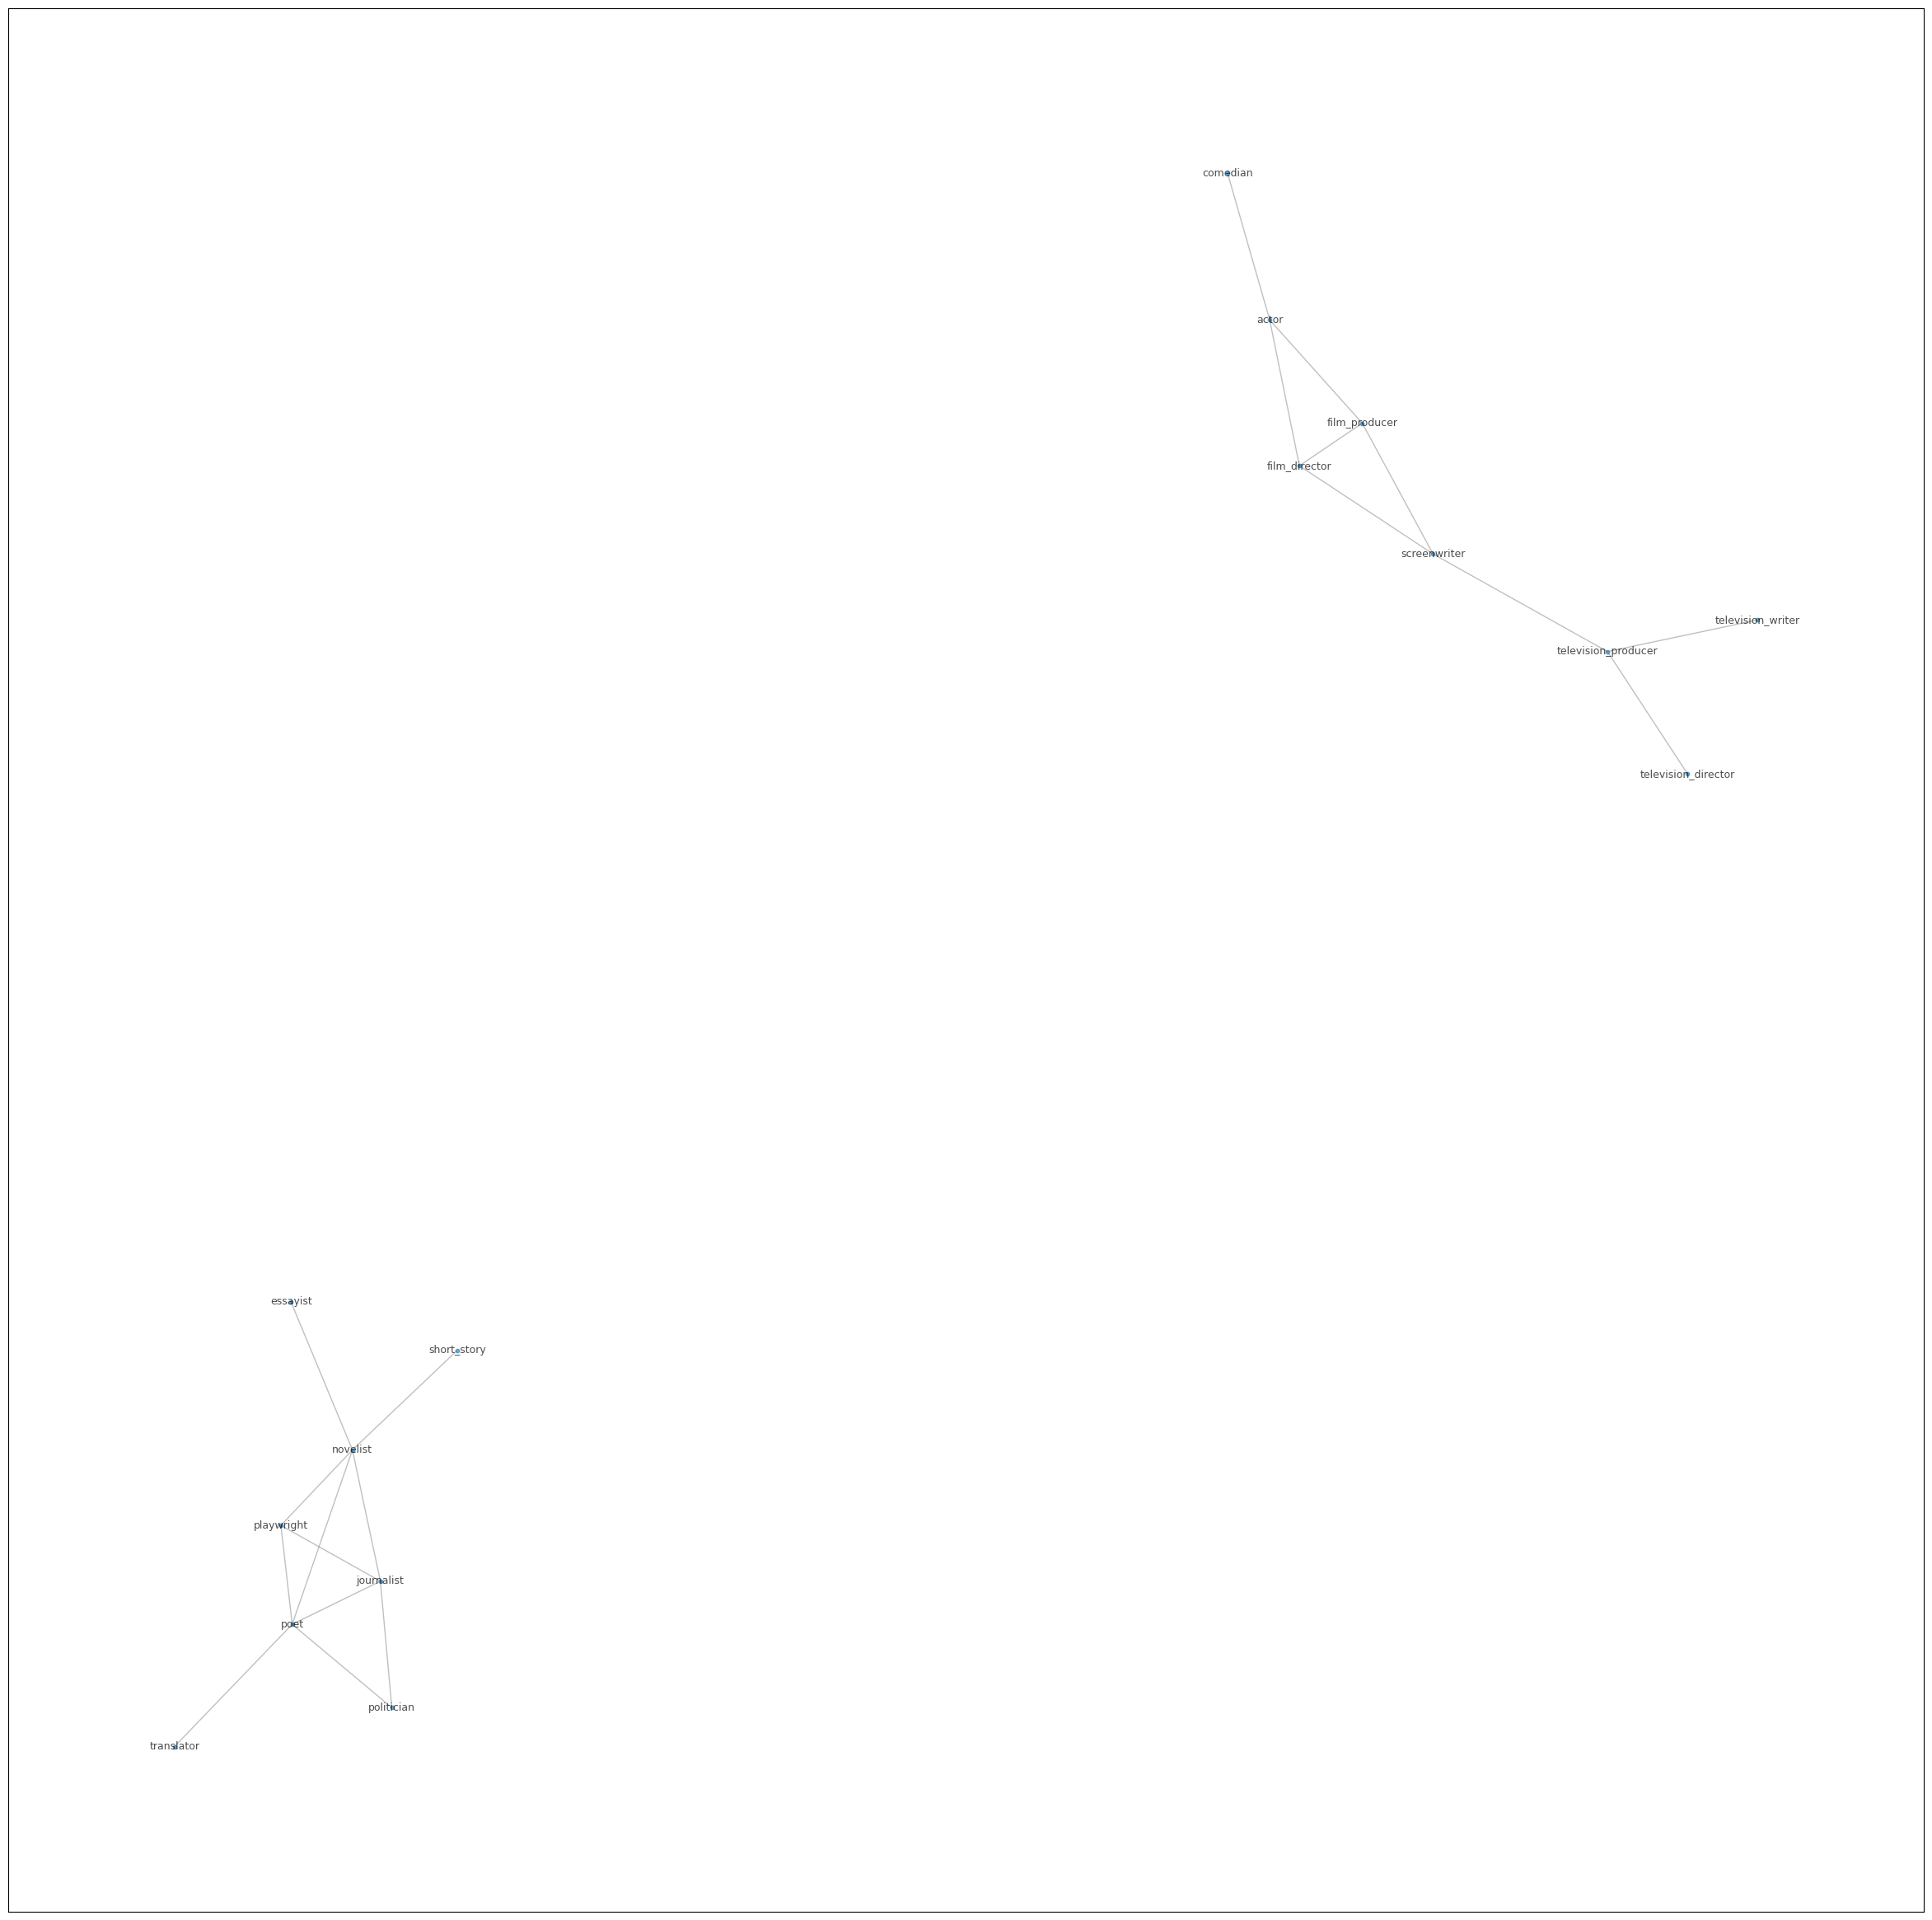

In [34]:
faire_un_graphe_simple_most_common(occ_pairs, 20)

En augmentant encore un peu le nombre de relations à intégrer dans le graphe jusqu'à relier les deux clusters, on peut voir que les occupations qui relient les deux clusters sont screenwriter et playwright, l'écriture pour le théâtre et l'écriture pour le cinéma: deux activités d'écriture qui incluent des formes de coopération avec et d'anticipation à l'égard des autres participant-es au monde de l'art concerné, par exemple au sujet de la manière dont le texte pourra être interprêté par les comédien-nes, mis en scène, produit. Les contraintes d'écritures (format, durée, etc.) relatives au monde chargé de diffuser l'oeuvre sont ainsi bien plus proches pour le théâtre et le cinéma qu'entre théâtre et roman (ni les romancier-ères ni les poète-sses n'ont à se demander si leur oeuvre pourra être matériellement fabriquée et mise en scène: cela est hors de leur écriture, mais fait intégralement partie de l'écriture des screenwriters et des playwrights).

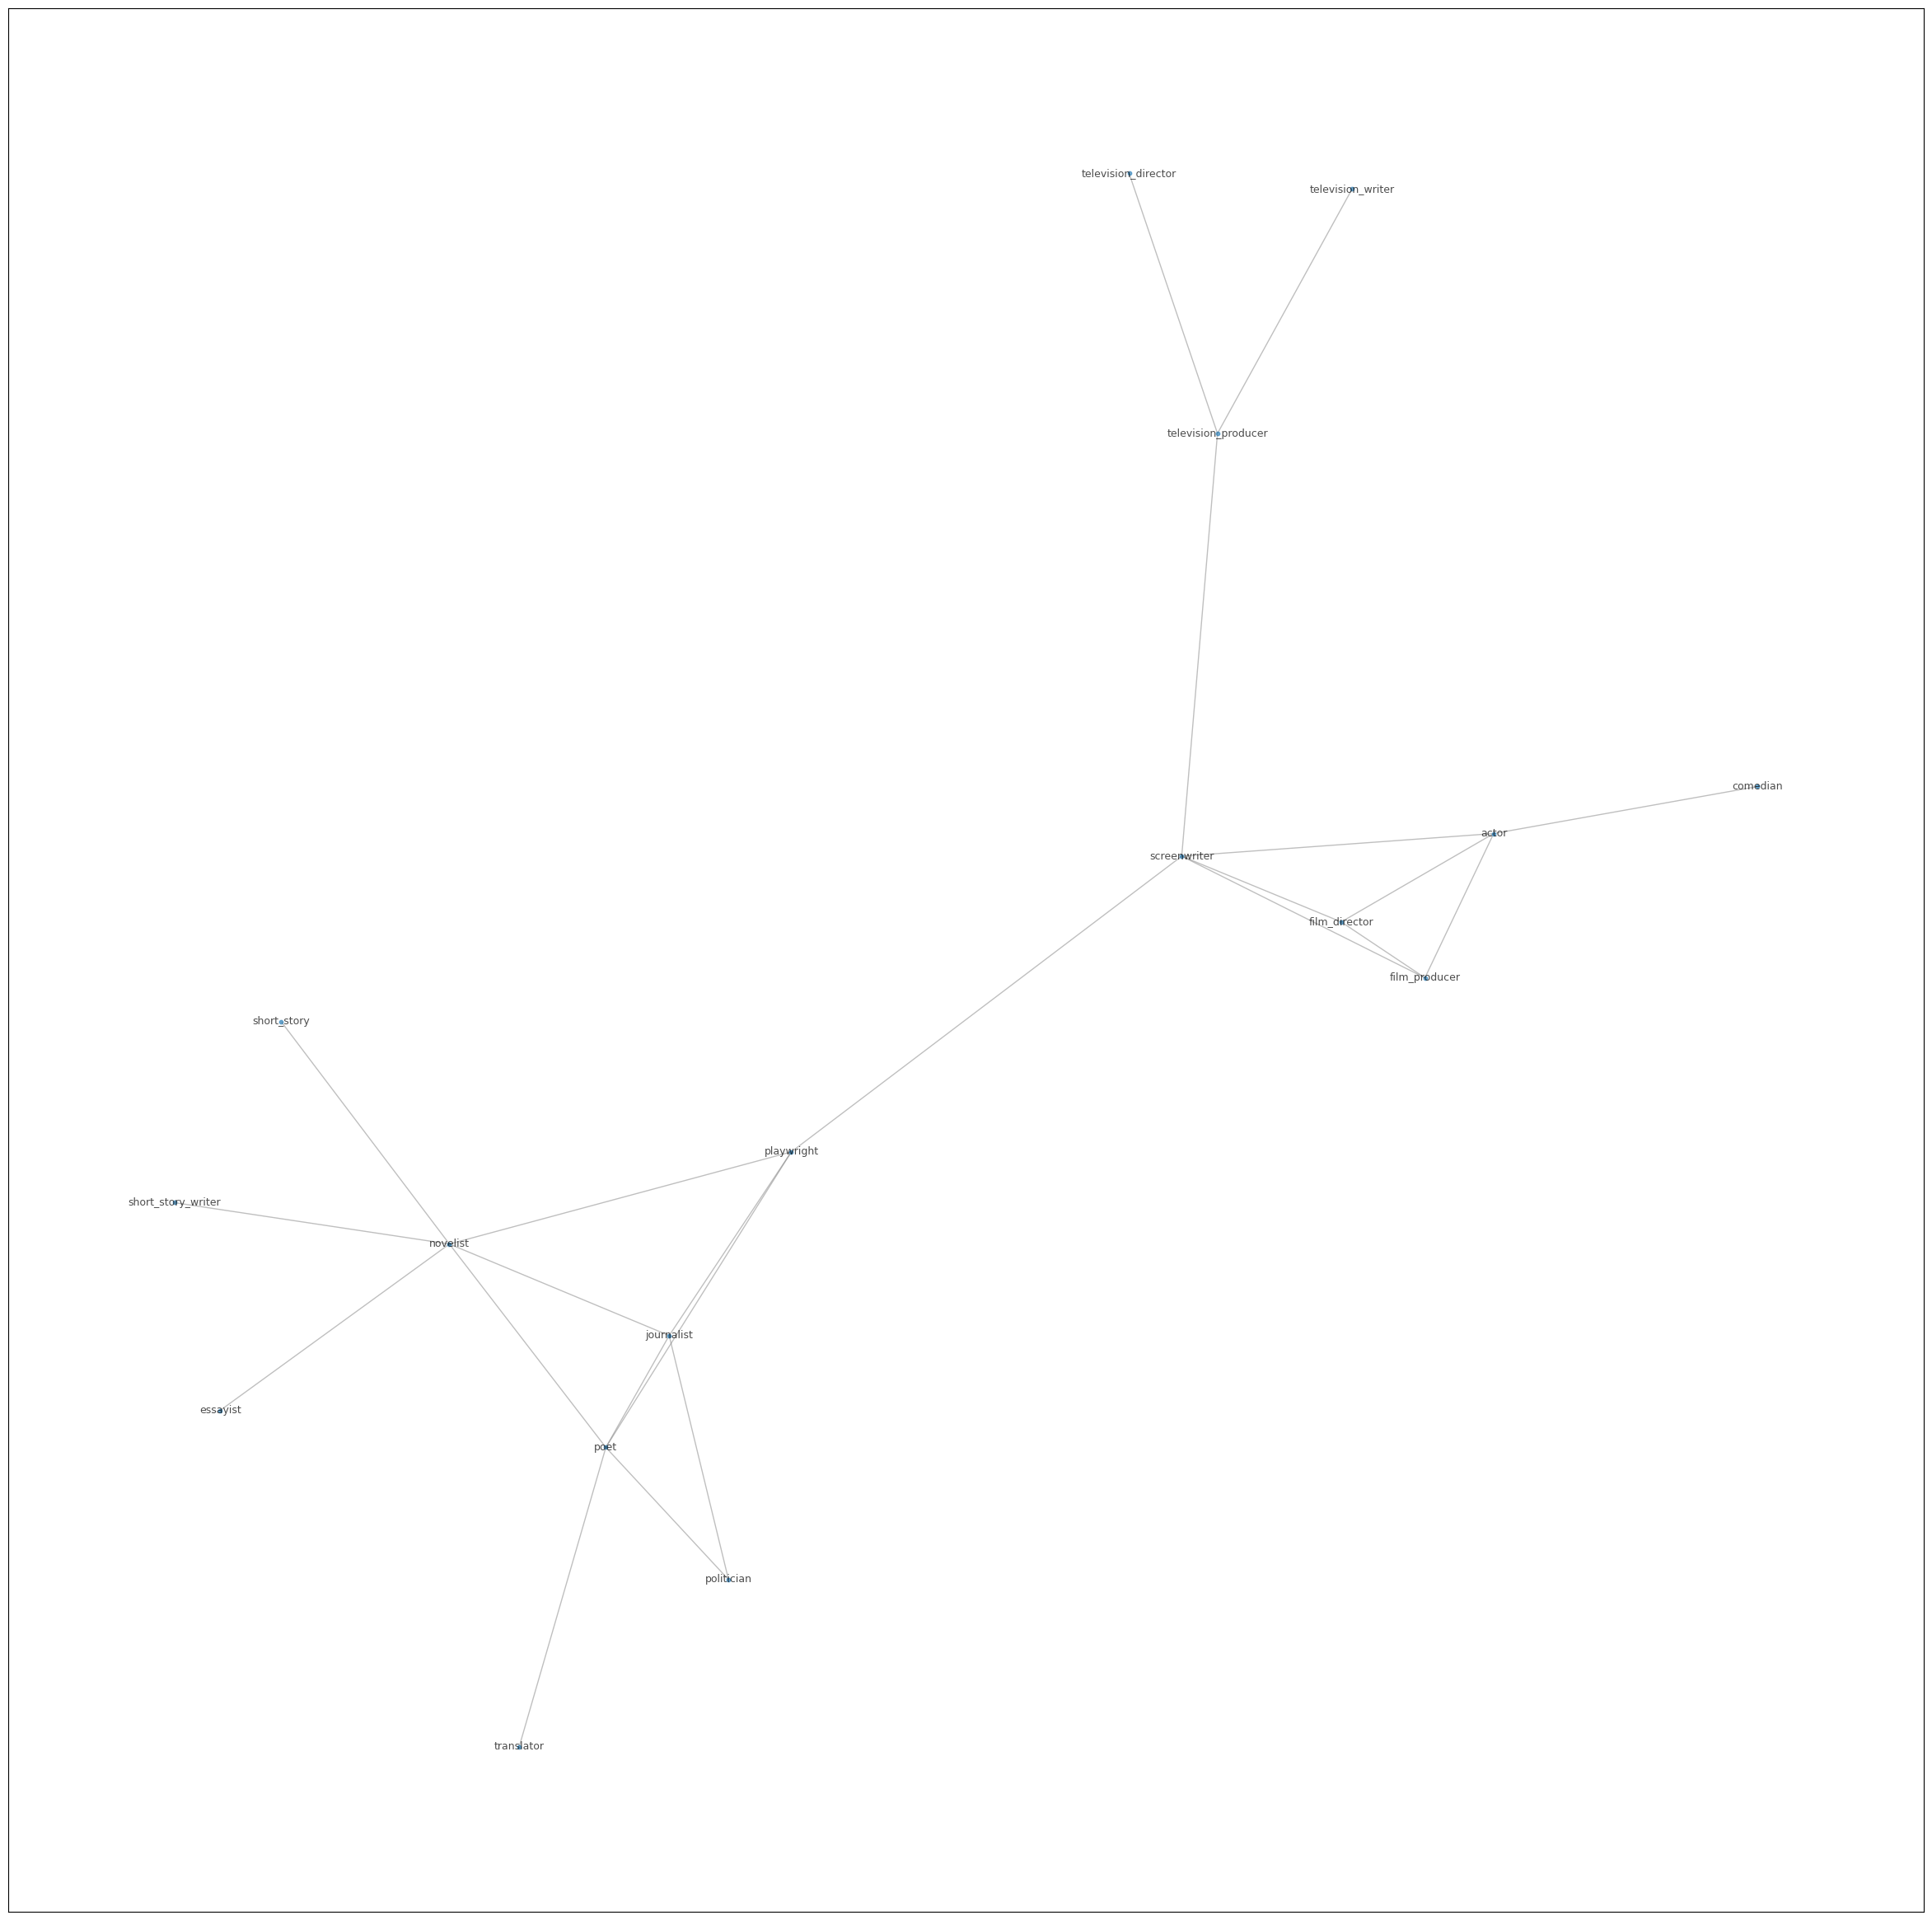

In [35]:
faire_un_graphe_simple_most_common(occ_pairs, 23)

Construire un graphe avec toutes les données. Impossible à visualiser, mais à partir duquel faire des recherches et produire des sous-graphes à visualiser.<br>
<br>
# Commencer par placer les nodes<br>
g = nx.Graph()<br>
for name, occupation in uniqpairs:<br>
    node_person = (name, {"node_type": "P"})<br>
    node_occupation = (occupation, {"node_type": "O"})<br>
    g.add_nodes_from([node_person])<br>
    g.add_nodes_from([node_occupation])<br>
    g.add_edge(name, occupation)<br>
<br>
# Puis les edges, avec un attribut "poids" (weight): le nombre de paires de ces occupations.<br>
count = Counter(occ_pairs).items()<br>
for occs, nb in count:<br>
    g.add_edges_from([(occs[0], occs[1], {"weight": nb})])<br>
<br>
start_node = "poet"<br>
end_node = "actor"<br>
a = nx.shortest_path_length(g, start_node, end_node)<br>
a<br>
#<br>
reachable_nodes = [<br>
    node<br>
    for node in g.nodes()<br>
    if nx.has_path(g, node, end_node)<br>
    and nx.has_path(g, start_node, node)<br>
    and nx.shortest_path_length(g, start_node, node) <= 2<br>
    and nx.shortest_path_length(g, node, end_node) <= 2<br>
]<br>
len(reachable_nodes)<br>
len([i for i in g.nodes()])